# Numerical approximations to the driven pendulum

In [1]:
import numpy as np

delta = 0.01
delta*( (4 / np.pi) * np.cosh((np.pi * 1)/2) )

np.float64(0.03194785263825852)

## Part (d)

Success: True
Periodic orbit initial condition: [3.04150605e+00 5.24166807e-04]


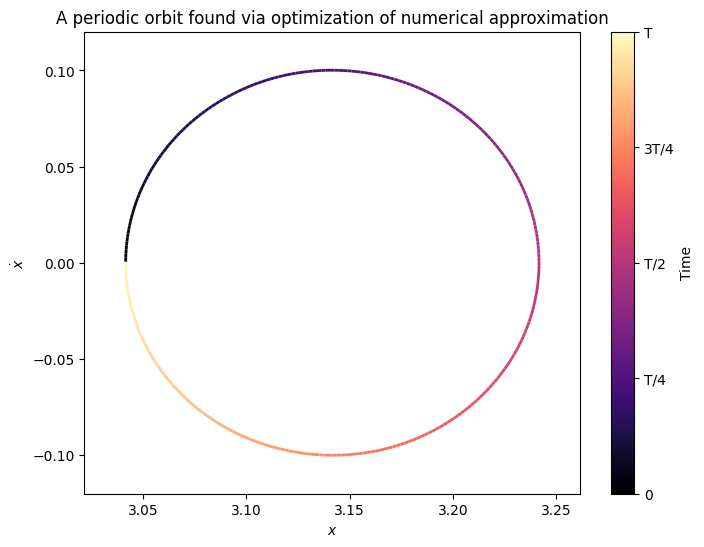

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection

from scipy.integrate import solve_ivp
from scipy import optimize


def driven_pendulum(t, z):
    delta, gamma, omega = 0.01, 0.2, 1.0
    x, y = z
    dx = y
    dy = -delta*y - np.sin(x) + gamma*np.cos(omega*t)
    return [dx,dy]

def residual(y0):
    t_span = (0, 2*np.pi)
    sol = solve_ivp(
        driven_pendulum, t_span, y0, 
        t_eval=np.linspace(0, 2*np.pi, 300)
    )
    return [sol.y[0][-1] - y0[0], sol.y[1][-1] - y0[1]]

guess = [np.pi, 0.0]
result = optimize.root(residual, guess, method='hybr')
print(f"Success: {result.success}")
print(f"Periodic orbit initial condition: {result.x}")

t_span = (0, 2*np.pi)
y0 = result.x
sol = solve_ivp(driven_pendulum, t_span, y0, t_eval=np.linspace(0, 2*np.pi, 300))

# Create segments for the line
points = np.array([sol.y[0], sol.y[1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Get the actual time values
T = 2*np.pi  # Period
times = sol.t  # Actual time array from solve_ivp

# Create a LineCollection with colors mapped to actual time
fig, ax = plt.subplots(figsize=(8, 6))
norm = plt.Normalize(0, T)
lc = LineCollection(segments, cmap='magma', norm=norm)
lc.set_array(times)  # Use actual times instead of indices
lc.set_linewidth(2)

line = ax.add_collection(lc)
cbar = fig.colorbar(line, ax=ax, label='Time')
cbar.set_ticks([0, T/4, T/2, 3*T/4, T])
cbar.set_ticklabels(['0', 'T/4', 'T/2', '3T/4', 'T'])

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\dot{x}$')
ax.set_title("A periodic orbit found via optimization of numerical approximation")
ax.autoscale()
ax.margins(0.1)

plt.savefig('problem_3_d.png', dpi=150, bbox_inches='tight')
plt.show()

## Part (e)

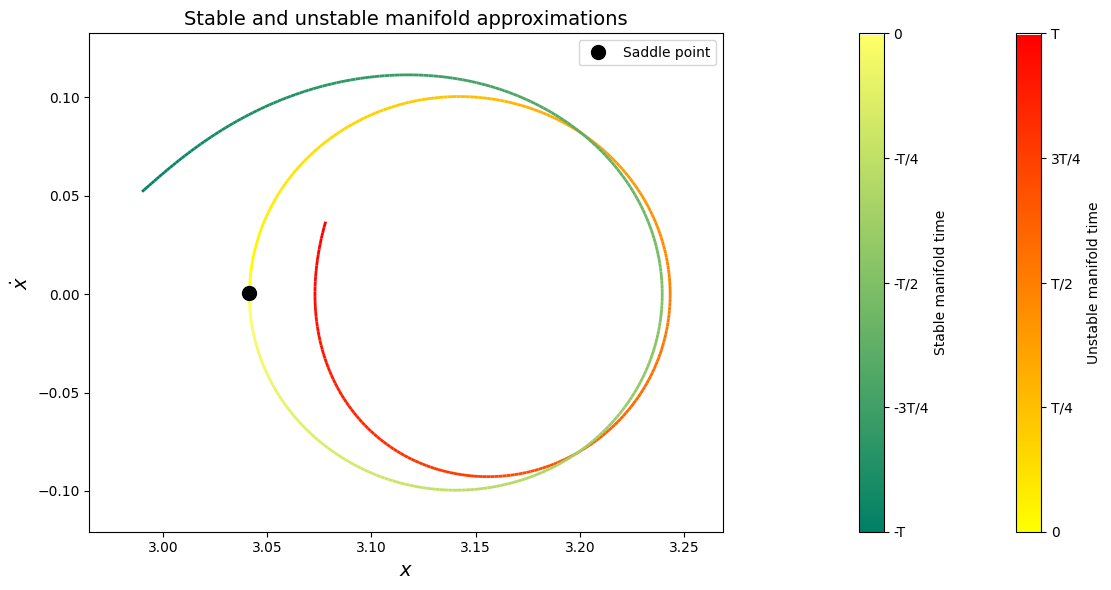

In [3]:
def poincare_map(y0):
    t_span = (0, 2*np.pi)
    sol = solve_ivp(driven_pendulum, t_span, y0, dense_output=True)
    return sol.y[:, -1]

def jacobian_finite_diff(y0, diff=1e-6):
    J = np.zeros((2, 2))
    yT = poincare_map(y0)
    for i in range(2):
        y_perturbed = y0.copy()
        y_perturbed[i] += diff
        yT_perturbed = poincare_map(y_perturbed)
        J[:, i] = (yT_perturbed - yT) / diff
    return J

# Approximate stable and unstable eigenspaces
jacobian = jacobian_finite_diff(y0)
eigen_comps = np.linalg.eig(jacobian)
eps = 0.0001

# Iterate a point on the unstable manifold forward
y_unstable = y0 + eps*eigen_comps.eigenvectors[:,0]
sol_unstable = solve_ivp(
    driven_pendulum, (0, 2*np.pi), y_unstable, 
    t_eval=np.linspace(0, 2*np.pi, 300)
)

# Iterate a point on the stable manifold backward
y_stable = y0 + eps*eigen_comps.eigenvectors[:,1]
sol_stable = solve_ivp(
    driven_pendulum, (0, -2*np.pi), y_stable, 
    t_eval=np.linspace(0, -2*np.pi, 300)
)

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot unstable manifold with autumn_r (reversed autumn, yellow at start)
points_unstable = np.array([sol_unstable.y[0], sol_unstable.y[1]]).T.reshape(-1, 1, 2)
segments_unstable = np.concatenate([points_unstable[:-1], points_unstable[1:]], axis=1)

norm_unstable = plt.Normalize(0, len(sol_unstable.t) - 1)
lc_unstable = LineCollection(segments_unstable, cmap='autumn_r', norm=norm_unstable)
lc_unstable.set_array(np.arange(len(sol_unstable.t)))
lc_unstable.set_linewidth(2)

line_unstable = ax.add_collection(lc_unstable)
cbar_unstable = fig.colorbar(line_unstable, ax=ax, label='Unstable manifold time', pad=0.02)
cbar_unstable.set_ticks([0, 300/4, 300/2, 3*300/4, 300])
cbar_unstable.set_ticklabels(['0', 'T/4', 'T/2', '3T/4', 'T'])

# Plot stable manifold with summer (yellow at end, which is near saddle)
points_stable = np.array([np.flip(sol_stable.y[0]), np.flip(sol_stable.y[1])]).T.reshape(-1, 1, 2)
segments_stable = np.concatenate([points_stable[:-1], points_stable[1:]], axis=1)

norm_stable = plt.Normalize(0, len(sol_stable.t) - 1)
lc_stable = LineCollection(segments_stable, cmap='summer', norm=norm_stable)
lc_stable.set_array(np.arange(len(sol_stable.t)))
lc_stable.set_linewidth(2)

line_stable = ax.add_collection(lc_stable)
cbar_stable = fig.colorbar(line_stable, ax=ax, label='Stable manifold time', pad=0.15)
cbar_stable.set_ticks([0, 300/4, 300/2, 3*300/4, 300])
cbar_stable.set_ticklabels(['-T', '-3T/4', '-T/2', '-T/4', '0'])

# Mark the saddle point
ax.plot(y0[0], y0[1], 'ko', markersize=10, label='Saddle point', zorder=5)

ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$\dot{x}$', fontsize=14)
ax.set_title('Stable and unstable manifold approximations', fontsize=14)
ax.legend()
ax.autoscale()
ax.margins(0.1)

plt.tight_layout()
plt.savefig('problem_3_e_manifolds.png', dpi=150, bbox_inches='tight')
plt.show()

In [4]:
eigen_comps

EigResult(eigenvalues=array([ 5.15278292e+02, -1.74208404e-02]), eigenvectors=array([[ 0.7096019 , -0.70629957],
       [ 0.70460283,  0.70791307]]))

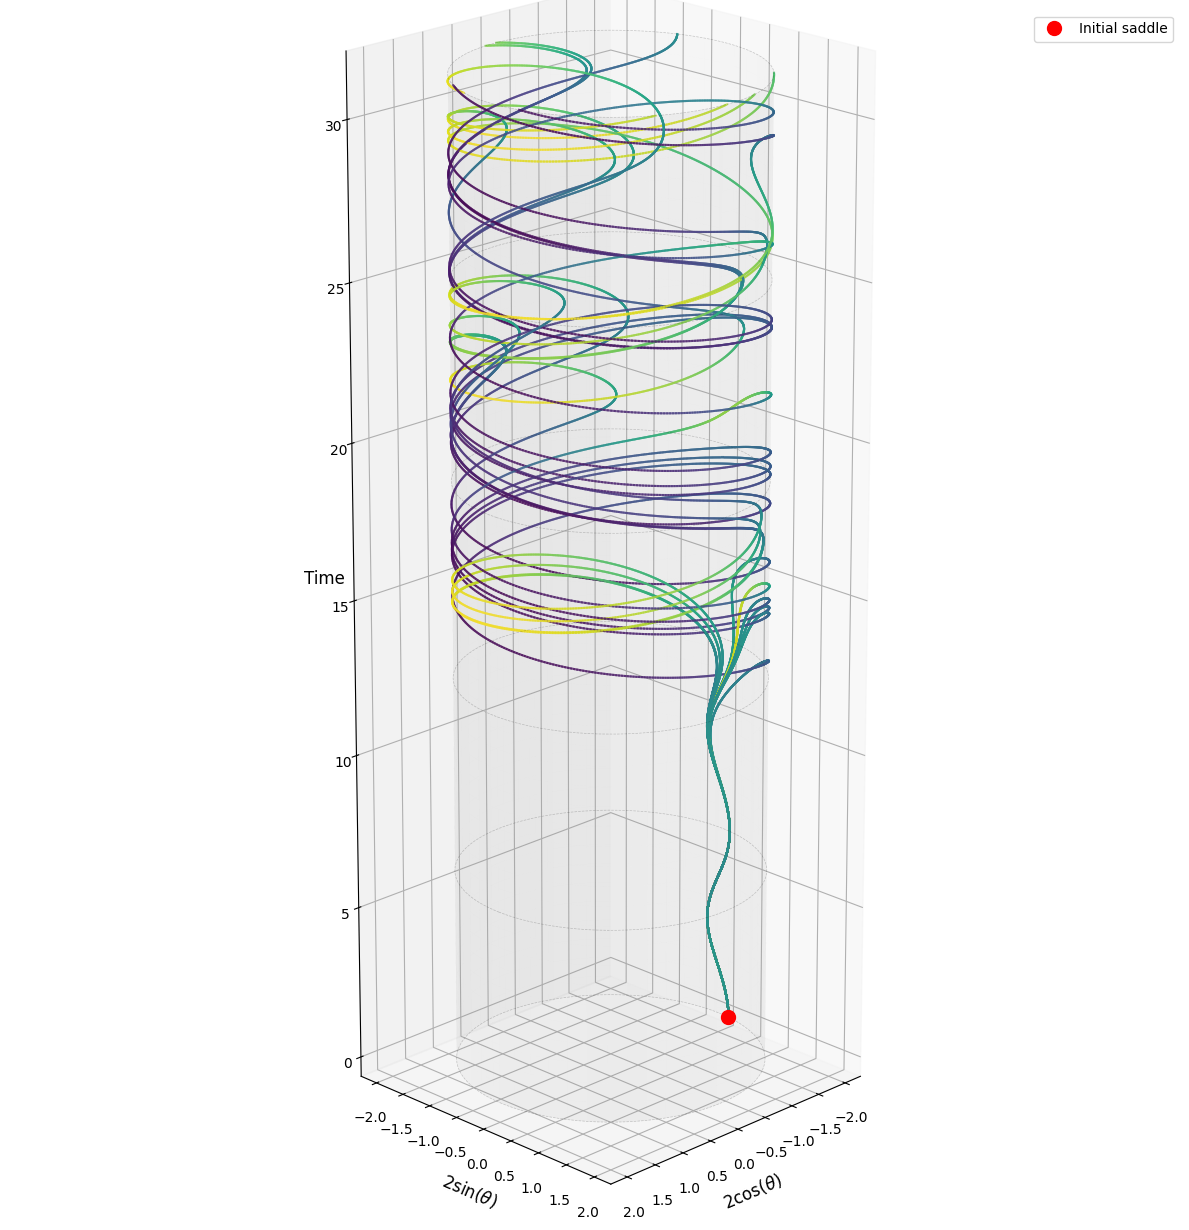

In [5]:
from mpl_toolkits.mplot3d import Axes3D

key = 42
rng = np.random.default_rng(seed=key)
eps = 0.000001

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

R = 2  # Cylinder radius
T = 2*np.pi  # Period

# Generate and plot trajectories
for i in range(10):
    y_rand = y0 + eps*rng.normal(size=2)
    sol_rand = solve_ivp(
        driven_pendulum, (0, 10*np.pi), y_rand, 
        t_eval=np.linspace(0, 10*np.pi, 3000)
    )
    
    theta = sol_rand.y[0]
    theta_dot = sol_rand.y[1]
    time = sol_rand.t
    
    # Map to cylinder: x = R*cos(θ), y = R*sin(θ), z = time
    # Color by velocity for visual clarity
    x = R * np.cos(theta)
    y = R * np.sin(theta)
    z = time
    
    # Color by theta_dot
    colors = plt.cm.viridis((theta_dot - theta_dot.min()) / (theta_dot.max() - theta_dot.min()))
    
    for j in range(len(x)-1):
        ax.plot(x[j:j+2], y[j:j+2], z[j:j+2], 
                color=colors[j], alpha=0.7, linewidth=1.5)

# Mark Poincaré sections at integer multiples of T
n_sections = int(10*np.pi / T)
for k in range(n_sections + 1):
    t_section = k * T
    theta_circle = np.linspace(0, 2*np.pi, 100)
    x_circle = R * np.cos(theta_circle)
    y_circle = R * np.sin(theta_circle)
    z_circle = np.full_like(theta_circle, t_section)
    ax.plot(x_circle, y_circle, z_circle, 'k--', alpha=0.2, linewidth=0.5)

# Draw the cylinder surface
theta_grid = np.linspace(0, 2*np.pi, 100)
t_grid = np.linspace(0, 10*np.pi, 50)
Theta_grid, T_grid = np.meshgrid(theta_grid, t_grid)
X_grid = R * np.cos(Theta_grid)
Y_grid = R * np.sin(Theta_grid)
ax.plot_surface(X_grid, Y_grid, T_grid, alpha=0.05, color='lightgray', edgecolor='none')

# Mark initial point
x0 = R * np.cos(y0[0])
y0_cyl = R * np.sin(y0[0])
ax.plot([x0], [y0_cyl], [0], 'ro', markersize=10, label='Initial saddle', zorder=10)

ax.set_xlabel(r'$2\cos(\theta)$', fontsize=12)
ax.set_ylabel(r'$2\sin(\theta)$', fontsize=12)
ax.set_zlabel('Time', fontsize=12)
ax.legend()

ax.set_box_aspect([1, 1, 3])
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig('spacetime_cylinder.png', dpi=150, bbox_inches='tight')
plt.show()